# NYC Taxi Tipping Behavior

## 1. Research Question

Question 1: "Do credit-card trips tip more than cash?"

Question 2: "What predicts tip amount?"

In this study, “tip more” is defined primarily in terms of the absolute tip amount rather than tip as a percentage of the fare. The absolute tip amount directly reflects customer tipping behavior and is easier to interpret in practical terms. While tip percentage is related to the absolute tip, it is not the primary focus of this analysis.

The analysis is intended to capture typical tipping behavior rather than extreme or unusual cases. Trips involving unusually long distances or atypical travel patterns may naturally result in higher tips due to higher fares, but these cases are not the main focus of this study. Instead, the goal is to understand average tipping behavior across standard taxi trips and to compare how tipping differs by payment method and trip characteristics.

## 2. Dataset Description

Dataset: NYC TLC Trip Record Data (yellow cabs) (PARQUET)

The dataset used in this study is the NYC TLC Yellow Taxi Trip Record Data, obtained from the official NYC government website (nyc.gov). 

The data are provided in Parquet format and include detailed trip-level information for yellow taxi rides in NYC.

Since the data is uploaded with a two-month delay, the most recent year of data is incomplete. 

Each row represents a single trip.

The dataset contains approximately 3.5 million observations for one month and includes 20 variables. Key variables relevant to this analysis includes the followings:

- Pick-Up and Drop-Off Time
- Passenger Count
- Trip Distance
- Rate Code
- Payment Type
- Fare Amount
- Total Amount
- Tip Amount

Due to the large size of the NYC TLC trip records (approximately 3–4 million observations per month), loading an entire year of data simultaneously can be computationally inefficient. To balance statistical robustness with practical constraints, the analysis is conducted on a month-by-month basis for the 2024 calendar year. Each month is processed using the same data cleaning and analysis pipeline, and the results are then combined to produce year-level summaries. This approach allows for scalable analysis while preserving a sufficiently large and representative sample.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_parquet("yellow_tripdata_2024-01.parquet")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0



## 3. Data Cleaning & Processing

- What is my outcome variable?
    - tip amount

- What variables are predictors?
    - payment_type: Q1 - two-sample inferene
    - trip_distance: Q2 - regression

- What variables help me filter invalid trips?
    - trip_distance missing
    - payment_type missing - cannot classify - problematic
    - fare amount/PU DO time missing or negative value - logically impossible


The primary outcome variable in this study is the absolute tip amount (`tip_amount`). Payment type (`payment_type`) is included as a key explanatory variable for comparing tipping behavior between credit card and cash transactions. In addition, trip distance (`trip_distance`) is included as a continuous predictor to examine whether trip characteristics are associated with tip amounts.

Initial Validity checks

In [2]:
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,2.964624e+06,2964624,2964624,2.824462e+06,2.964624e+06,2.824462e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.824462e+06,2.824462e+06
mean,1.754204e+00,2024-01-17 00:46:36.431095552,2024-01-17 01:02:13.208131328,1.339281e+00,3.652169e+00,2.069359e+00,1.660179e+02,1.651167e+02,1.161271e+00,1.817506e+01,1.451598e+00,4.833823e-01,3.335870e+00,5.270212e-01,9.756319e-01,2.680150e+01,2.256122e+00,1.411611e-01
min,1.000000e+00,2002-12-31 22:59:39,2002-12-31 23:05:41,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-8.990000e+02,-7.500000e+00,-5.000000e-01,-8.000000e+01,-8.000000e+01,-1.000000e+00,-9.000000e+02,-2.500000e+00,-1.750000e+00
25%,2.000000e+00,2024-01-09 15:59:19.750000128,2024-01-09 16:16:23,1.000000e+00,1.000000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.538000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2024-01-17 10:45:37.500000,2024-01-17 11:03:51.500000,1.000000e+00,1.680000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.700000e+00,0.000000e+00,1.000000e+00,2.010000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2024-01-24 18:23:52.249999872,2024-01-24 18:40:29,1.000000e+00,3.110000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.120000e+00,0.000000e+00,1.000000e+00,2.856000e+01,2.500000e+00,0.000000e+00
max,6.000000e+00,2024-02-01 00:01:15,2024-02-02 13:56:52,9.000000e+00,3.127223e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,5.000000e+03,1.425000e+01,4.000000e+00,4.280000e+02,1.159200e+02,1.000000e+00,5.000000e+03,2.500000e+00,1.750000e+00
std,4.325902e-01,NaN,NaN,8.502817e-01,2.254626e+02,9.823219e+00,6.362391e+01,6.931535e+01,5.808686e-01,1.894955e+01,1.804102e+00,1.177600e-01,3.896551e+00,2.128310e+00,2.183645e-01,2.338558e+01,8.232747e-01,4.876239e-01


Suspicious Extreme Values
- Trip distance = 312,000
- Fare/Total = $5,0000
- Negative Components

In [3]:
df[
    (df["trip_distance"] <= 0) |
    (df["fare_amount"] <= 0) |
    (df["tip_amount"] < 0)
]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
17,2,2024-01-01 00:52:09,2024-01-01 00:52:28,1.0,0.00,1.0,N,237,237,2,3.00,1.0,0.5,0.00,0.0,1.0,8.00,2.5,0.0
23,1,2024-01-01 00:14:29,2024-01-01 00:14:29,1.0,0.00,1.0,N,236,264,2,3.00,3.5,0.5,0.00,0.0,1.0,8.00,2.5,0.0
99,2,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,1.0,N,249,232,4,-13.50,-1.0,-0.5,0.00,0.0,-1.0,-18.50,-2.5,0.0
111,1,2024-01-01 00:58:50,2024-01-01 01:01:10,1.0,0.00,1.0,N,162,162,1,4.40,3.5,0.5,2.00,0.0,1.0,11.40,2.5,0.0
198,1,2024-01-01 00:15:16,2024-01-01 00:26:58,2.0,0.00,1.0,N,79,264,1,10.70,3.5,0.5,3.10,0.0,1.0,18.80,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964528,1,2024-01-31 22:24:07,2024-01-31 22:36:32,NaN,0.00,NaN,None,140,239,0,14.00,2.0,0.5,1.85,0.0,1.0,23.85,NaN,NaN
2964535,1,2024-01-31 22:23:49,2024-01-31 22:31:13,NaN,0.00,NaN,None,161,68,0,9.67,0.0,0.5,0.00,0.0,1.0,13.67,NaN,NaN
2964540,1,2024-01-31 22:09:21,2024-01-31 22:21:43,NaN,0.00,NaN,None,48,234,0,14.25,0.0,0.5,0.00,0.0,1.0,18.25,NaN,NaN
2964550,1,2024-01-31 22:18:18,2024-01-31 22:32:15,NaN,0.00,NaN,None,164,79,0,10.75,0.0,0.5,0.00,0.0,1.0,14.75,NaN,NaN


1. Trip Distance $\le$ 0
2. Fare Amount $\le$ 0
3. Tip amount $\lt$ 0

These records do not represent completed, positive-fare taxi trips and are therefore not meaningful for analyzing tipping behavior.



In [4]:
df[
    (df["payment_type"] == 2) &
    (df["tip_amount"] == 0)
]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.0,0.0,1.0,22.70,2.5,0.00
7,1,2024-01-01 00:30:40,2024-01-01 00:58:40,0.0,3.00,1.0,N,246,231,2,25.4,3.5,0.5,0.0,0.0,1.0,30.40,2.5,0.00
8,2,2024-01-01 00:26:01,2024-01-01 00:54:12,1.0,5.44,1.0,N,161,261,2,31.0,1.0,0.5,0.0,0.0,1.0,36.00,2.5,0.00
9,2,2024-01-01 00:28:08,2024-01-01 00:29:16,1.0,0.04,1.0,N,113,113,2,3.0,1.0,0.5,0.0,0.0,1.0,8.00,2.5,0.00
14,1,2024-01-01 00:51:53,2024-01-01 00:55:43,1.0,0.80,1.0,N,90,68,2,6.5,3.5,0.5,0.0,0.0,1.0,11.50,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2824440,2,2024-01-31 23:30:51,2024-02-01 00:16:08,1.0,27.78,1.0,N,132,255,2,101.0,1.0,0.5,0.0,0.0,1.0,105.25,0.0,1.75
2824444,1,2024-01-31 23:44:29,2024-01-31 23:56:23,2.0,1.30,1.0,N,68,246,2,10.0,3.5,0.5,0.0,0.0,1.0,15.00,2.5,0.00
2824450,2,2024-01-31 23:25:48,2024-01-31 23:25:55,1.0,0.00,2.0,N,50,50,2,70.0,0.0,0.5,0.0,0.0,1.0,74.00,2.5,0.00
2824451,2,2024-01-31 23:26:33,2024-01-31 23:29:26,1.0,0.09,1.0,N,50,50,2,4.4,1.0,0.5,0.0,0.0,1.0,9.40,2.5,0.00


`payment_types == 1`: Cash

`payment_types == 2`: Credit Card

- No tip when paid cash: 439,063
- No tip when paid card: 114,188

A large proportion of cash transactions have recorded zero tip amounts, which is consistent with tipping being unobserved or unrecorded for cash payments.

#### Cleaning Rules

The following records are excluded from the analysis:
1. Trips with non-positive fare amounts, as these do not represent completed, metered taxi trips.
2. Trips with non-positive trip distances, which are physically implausible.
3. Trips with negative tip amounts, which reflect adjustments or refunds rather than tipping behavior.
4. Trips with payment types other than credit card or cash, as these do not represent voluntary payment decisions relevant to the research question.

These rules are applied uniformly across all months of data.

In [5]:
df_raw = df.copy()
df_clean = df_raw.copy()

start = pd.Timestamp("2024-01-01")
end = pd.Timestamp("2024-02-01")

df_clean = df_clean[
    (df_clean["fare_amount"] > 0) &
    (df_clean["trip_distance"] > 0) &
    (df_clean["tip_amount"] >= 0) &
    (df_clean["payment_type"].isin([1, 2])) &
    (df_clean["tpep_pickup_datetime"] >= start) &
    (df_clean["tpep_pickup_datetime"] < end) &
    (df_clean["tpep_pickup_datetime"] < df_clean["tpep_dropoff_datetime"])
]

print(f"Rows before cleaning: {len(df_raw)}")
print(f"Rows after cleaning: {len(df_clean)}")
print(f"Rows removed: {len(df_raw) - len(df_clean)}")

Rows before cleaning: 2964624
Rows after cleaning: 2721070
Rows removed: 243554


#### Derived Variables
- Trip duration: Dropoff time - Pickup time (minutes)
    - validates physical plausibility
    - Potential Control Variable

- Tip Percentage: Tip amount / Fare amount (fare > 0 only)
    - Normalizes tipping across fares
    - Used for robustness checks
    
- Credit vs Cash indicator: 1 = Credit Card, 2 = Cash
    - Simplifies group comparisons
    - Aligns with research question
    

In [6]:
df_clean["trip_duration_min"] = (
    df_clean["tpep_dropoff_datetime"] - df_clean["tpep_pickup_datetime"]
).dt.total_seconds() / 60

df_clean["tip_percentage"] = (
    df_clean["tip_amount"] / df_clean["fare_amount"] * 100
)

df_clean["is_credit"] = (df_clean["payment_type"] == 1).astype(int)

df_clean

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_duration_min,tip_percentage,is_credit
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,...,0.5,0.00,0.0,1.0,22.70,2.5,0.00,19.800000,0.000000,0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,...,0.5,3.75,0.0,1.0,18.75,2.5,0.00,6.600000,37.500000,1
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,...,0.5,3.00,0.0,1.0,31.30,2.5,0.00,17.916667,12.875536,1
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,...,0.5,2.00,0.0,1.0,17.00,2.5,0.00,8.300000,20.000000,1
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,...,0.5,3.20,0.0,1.0,16.10,2.5,0.00,6.100000,40.506329,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2824457,2,2024-01-31 23:10:28,2024-01-31 23:18:30,1.0,3.51,1.0,N,138,129,1,...,0.5,4.76,0.0,1.0,30.31,0.0,1.75,8.033333,29.202454,1
2824458,2,2024-01-31 23:01:04,2024-01-31 23:17:35,1.0,3.36,1.0,N,162,261,1,...,0.5,5.85,0.0,1.0,29.25,2.5,0.00,16.516667,31.793478,1
2824459,1,2024-01-31 23:08:13,2024-01-31 23:25:00,3.0,3.30,1.0,N,43,249,1,...,0.5,1.00,0.0,1.0,23.70,2.5,0.00,16.783333,5.649718,1
2824460,1,2024-01-31 23:49:46,2024-01-31 23:53:10,0.0,0.40,1.0,N,142,163,2,...,0.5,0.00,0.0,1.0,10.10,2.5,0.00,3.400000,0.000000,0


In [7]:
df_clean[df_clean["tip_percentage"] > 2000].iloc[0]

VendorID                                   2
tpep_pickup_datetime     2024-01-05 16:35:30
tpep_dropoff_datetime    2024-01-05 16:35:35
passenger_count                          4.0
trip_distance                           0.01
RatecodeID                               1.0
store_and_fwd_flag                         N
PULocationID                             226
DOLocationID                             260
payment_type                               1
fare_amount                              3.0
extra                                    2.5
mta_tax                                  0.5
tip_amount                              70.0
tolls_amount                             0.0
improvement_surcharge                    1.0
total_amount                            77.0
congestion_surcharge                     0.0
Airport_fee                              0.0
trip_duration_min                   0.083333
tip_percentage                   2333.333333
is_credit                                  1
Name: 3820


## 4. Exploratory Analysis

### Sample Overview

In [8]:
df_clean.shape

(2721070, 22)

In [9]:
df_clean["payment_type"].value_counts()

payment_type
1    2298339
2     422731
Name: count, dtype: int64

After applying the cleaning rule, 2,721,070 rows remaining for January 2024 data, which is 91.7846% of the raw data. Currently payment type is sorted down to 1. Credit card, 2. Cash.

### Distribution of key variables

- `tip_amount` (primary outcome)

In [10]:
df_clean["tip_amount"].describe()

count    2.721070e+06
mean     3.509516e+00
std      3.850713e+00
min      0.000000e+00
25%      1.320000e+00
50%      2.850000e+00
75%      4.250000e+00
max      4.227000e+02
Name: tip_amount, dtype: float64

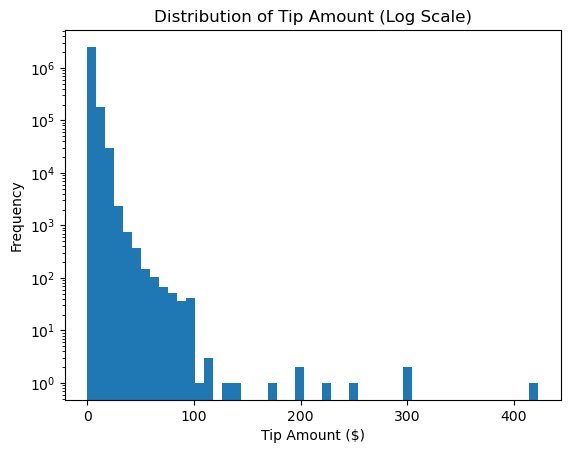

In [11]:
plt.figure()
plt.hist(df_clean["tip_amount"] + 0.01, bins=50, log=True)
plt.xlabel("Tip Amount ($)")
plt.ylabel("Frequency")
plt.title("Distribution of Tip Amount (Log Scale)")
plt.show()

`tip_amount` is heavily right-skewed. Most observations fall between 0 and 100 dollars, with counts dropping sharply above 100 dollars. Tips in the 100 to 200 dollar range may be plausible for high-fare trips, but tips above about 300 to 400 dollars appear unusually large and will be investigated as potential anomalies.

In [12]:
df_clean["tip_percentage"].describe()

count    2.721070e+06
mean     2.219260e+01
std      8.828520e+02
min      0.000000e+00
25%      1.162791e+01
50%      2.484663e+01
75%      3.000000e+01
max      1.400000e+06
Name: tip_percentage, dtype: float64

Half of all trips had a tip of about 25% of the fare or less, which suggests that ~25% is a very typical tip in the data, which is broadly consistent with common tipping ranges.

A maximum tip percentage had extremely large values: 1,400,000\% - clearly not realistic. This makes the standard deviation as `sd = 882.85`, which tells the distribution of tip_percentage is very spread out, and these extreme outliers distort the summary statistics.

For readability, the histogram is truncated using an IQR-based upper bound `(Q3 + 1.5 * IQR)` Values above this bound are retained in the dataset but not shown in the plot.

In [13]:
q1 = df_clean["tip_percentage"].quantile(0.25)
q3 = df_clean["tip_percentage"].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
upper_bound

57.55813953488372

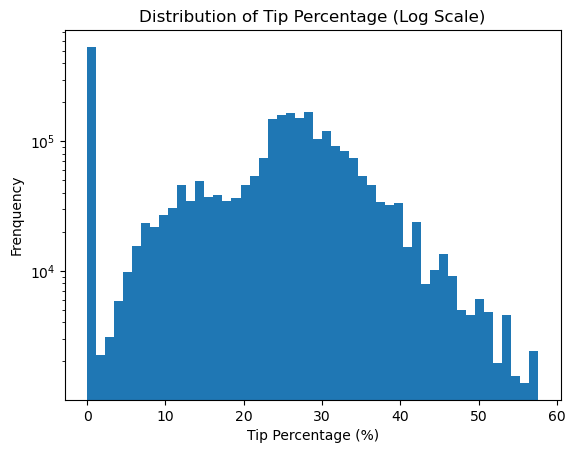

In [14]:
plt.figure()
plt.hist(df_clean.loc[df_clean["tip_percentage"] <= upper_bound, "tip_percentage"] + 0.01, bins=50, log=True)
plt.xlabel("Tip Percentage (%)")
plt.ylabel("Frenquency")
plt.title("Distribution of Tip Percentage (Log Scale)")
plt.show()


## 5. Statistical Inference

## 6. Regression Analysis

## 7. Conclusions & Limitations